# Exponential cutoff

In [58]:
from functools import partial

import pysme.hierarchy as hier
import numpy as np
from scipy.special import lambertw, factorial

In [3]:
hard_cutoff_factories = {n_max: hier.HierarchyIntegratorFactory(2, n_max)
                         for n_max in range(1, 10+1)}

Want to pick `n_max` based of the decay constant $\lambda$ in $e^{-n/\lambda}$ used in
\begin{align}
    A_\text{exp}
    &=
    \sum_n e^{-n/\lambda}\sqrt{n+1}\left|n\middle\rangle\middle\langle n+1\right|
\end{align}

Basically want to pick it so that the elements we're throwing away are all smaller than some threshold $\varepsilon$, say $\sim1/2$.

\begin{align}
    e^{-n_\text{max}/\lambda}\sqrt{n_\text{max}+1}
    &=
    \varepsilon
\end{align}

Squaring gets me

\begin{align}
    e^{-2n_\text{max}/\lambda}(n_\text{max}+1)
    &=
    \varepsilon^2
\end{align}

Multiplying both sides by $-e^{-2/\lambda}(2/\lambda)$ gets me

\begin{align}
    -e^{-(2/\lambda)(n_\text{max}+1)}(2/\lambda)(n_\text{max}+1)
    &=
    -e^{-2/\lambda}(2/\lambda)\varepsilon^2
\end{align}

This is of the form $we^w=z$, which we can solve for using the Lambert w function: $W_k(z)=w$

In [18]:
def calc_n_max(decay_const, threshold=0.5):
    z = -np.exp(-2/decay_const)*(2/decay_const)*threshold**2
    w = lambertw(z, k=-1).real
    n_max = -decay_const*w/2 - 1
    return n_max

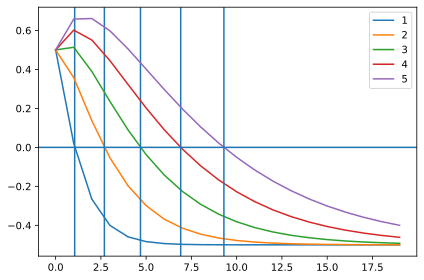

In [19]:
ns = np.arange(20)
decay_consts = np.arange(1, 6)
threshold = 0.5
plt.axhline(0)
for decay_const in decay_consts:
    n_max = calc_n_max(decay_const)
    plt.plot(ns, np.exp(-ns/decay_const)*np.sqrt(ns + 1) - threshold, label=decay_const)
    plt.axvline(n_max)
plt.legend()
plt.tight_layout()

In [20]:
exp_cutoff_factories = {decay_const: hier.HierarchyIntegratorFactoryExpCutoff(2, int(np.floor(calc_n_max(decay_const))), decay_const)
                        for decay_const in range(1, 10+1)}

In [22]:
[(decay_const, factory.n_max) for decay_const, factory in exp_cutoff_factories.items()]

In [23]:
def xi_gau(t, Omega, ta):
    return np.power(Omega**2/(2*np.pi), 1/4) * np.exp(-Omega**2*(t - ta)**2/4)

In [24]:
# Define Lowering operator and Sigma Z

Id = np.eye(2, dtype=complex)

zero = np.zeros((2,2), dtype=complex)

sigz = np.array([[1, 0], [0, -1]], dtype=complex)

sigm = np.array([[0, 0], [1, 0]], dtype=complex)

In [29]:
S = Id
L = sigm
H = zero
r = np.log(2)
mu = 0
hard_cutoff_integrators = {n_max: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                           for n_max, factory in hard_cutoff_factories.items()}
exp_cutoff_integrators = {decay_const: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                          for decay_const, factory in exp_cutoff_factories.items()}

In [59]:
def make_squeezed_state_vec(r, phi, N, normalized=True):                                                 
    r'''Make a truncated squeezed-state vector.                                                          

    The squeezed-state vector is :math:`S(r,\phi)|0\rangle`. The truncated                               
    vector is renormalized by default.                                                                   

    Parameters                                                                                           
    ----------
    N: positive integer
        The dimension of the truncated Hilbert space, basis {0, ..., N-1}                                
    r: real number
        Squeezing amplitude                                                                              
    phi: real number
        Squeezing phase                                                                                  
    normalized: boolean
        Whether or not the truncated vector is renormalized                                              

    Returns                                                                                              
    -------
    numpy.array
        Squeezed-state vector in the truncated Hilbert space, represented in the                         
        number basis                                                                                     

    ''' 
    ket = np.zeros(N, dtype=np.complex)                                                                  
    for n in range(N//2):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * phi) * np.tanh(r))**n /             
                                                factorial(n)) * np.sqrt(factorial(2 * n))                
    return ket / np.linalg.norm(ket) if normalized else ket

In [90]:
fock_factory = hier.HierarchyIntegratorFactory(2, 20)
fock_integrator = fock_factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, 0, 0)

In [92]:
fock_soln = fock_integrator.integrate(rho0, times)

In [95]:
fock_field_ket = make_squeezed_state_vec(np.log(2), mu, 20 + 1)
fock_field_ket_er_3 = make_squeezed_state_vec(np.log(3), mu, 20 + 1)
fock_field_ket_er_4 = make_squeezed_state_vec(np.log(4), mu, 20 + 1)
fock_field_rho = np.outer(fock_field_ket, fock_field_ket)
fock_field_rho_er_3 = np.outer(fock_field_ket_er_3, fock_field_ket_er_3)
fock_field_rho_er_4 = np.outer(fock_field_ket_er_4, fock_field_ket_er_4)

In [31]:
rho0 = (Id - sigz)/2
times = np.linspace(-3, 3, 2**8)
hard_cutoff_solns = {n_max: integrator.integrate(rho0, times) for n_max, integrator in hard_cutoff_integrators.items()}
exp_cutoff_solns = {decay_const: integrator.integrate(rho0, times) for decay_const, integrator in exp_cutoff_integrators.items()}

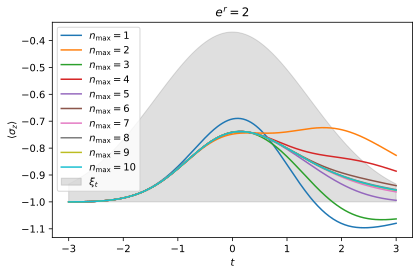

In [80]:
for n_max, soln in hard_cutoff_solns.items():
    field_ket = np.array([1] + n_max*[0])
    field_rho = np.outer(field_ket, field_ket)
    plt.plot(times, soln.get_expectations(sigz, field_rho), label=r'$n_\mathrm{{max}}={}$'.format(n_max))
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=2$')
plt.legend()
plt.tight_layout()

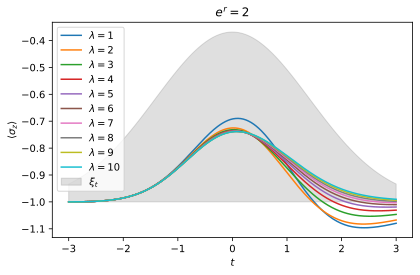

In [77]:
for decay_const, soln in exp_cutoff_solns.items():
    field_ket = np.array([1] + exp_cutoff_factories[decay_const].n_max*[0])
    field_rho = np.outer(field_ket, field_ket)
    plt.plot(times, soln.get_expectations(sigz, field_rho), label=r'$\lambda={}$'.format(decay_const))
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=2$')
plt.legend()
plt.tight_layout()

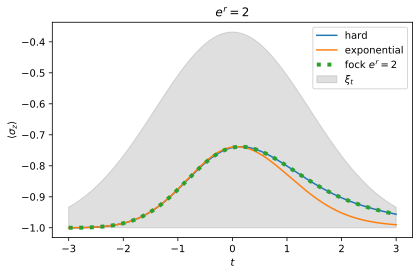

In [97]:
n_max = 10
hard_field_ket = np.array([1] + n_max*[0])
hard_field_rho = np.outer(hard_field_ket, hard_field_ket)
plt.plot(times, hard_cutoff_solns[n_max].get_expectations(sigz, hard_field_rho), label='hard')
decay_const = 10
exp_field_ket = np.array([1] + exp_cutoff_factories[decay_const].n_max*[0])
exp_field_rho = np.outer(exp_field_ket, exp_field_ket)
plt.plot(times, exp_cutoff_solns[n_max].get_expectations(sigz, exp_field_rho), label='exponential')
plt.plot(times, fock_soln.get_expectations(sigz, fock_field_rho), linestyle=':', linewidth=4, label='fock $e^r=2$')
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=2$')
plt.legend()
plt.tight_layout()

In [35]:
r = np.log(4)
hard_cutoff_integrators_er_4 = {n_max: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                                for n_max, factory in hard_cutoff_factories.items()}
exp_cutoff_integrators_er_4 = {decay_const: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                               for decay_const, factory in exp_cutoff_factories.items()}

In [35]:
r = np.log(4)
hard_cutoff_integrators_er_4 = {n_max: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                                for n_max, factory in hard_cutoff_factories.items()}
exp_cutoff_integrators_er_4 = {decay_const: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                               for decay_const, factory in exp_cutoff_factories.items()}

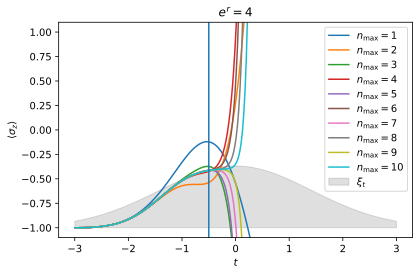

In [83]:
for n_max, soln in hard_cutoff_solns_er_4.items():
    field_ket = np.array([1] + n_max*[0])
    field_rho = np.outer(field_ket, field_ket)
    plt.plot(times, soln.get_expectations(sigz, field_rho), label=r'$n_\mathrm{{max}}={}$'.format(n_max))
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=4$')
plt.axvline(-.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.tight_layout()

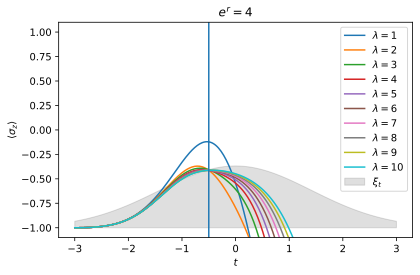

In [84]:
for decay_const, soln in exp_cutoff_solns_er_4.items():
    field_ket = np.array([1] + exp_cutoff_factories[decay_const].n_max*[0])
    field_rho = np.outer(field_ket, field_ket)
    plt.plot(times, soln.get_expectations(sigz, field_rho), label=r'$\lambda={}$'.format(decay_const))
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=4$')
plt.axvline(-.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.tight_layout()

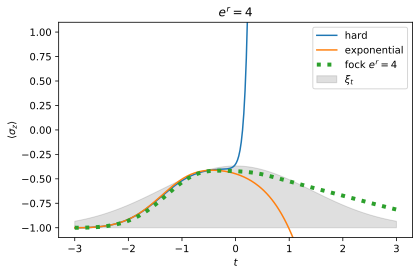

In [98]:
n_max = 10
hard_field_ket = np.array([1] + n_max*[0])
hard_field_rho = np.outer(hard_field_ket, hard_field_ket)
plt.plot(times, hard_cutoff_solns_er_4[n_max].get_expectations(sigz, hard_field_rho), label='hard')
decay_const = 10
exp_field_ket = np.array([1] + exp_cutoff_factories[decay_const].n_max*[0])
exp_field_rho = np.outer(exp_field_ket, exp_field_ket)
plt.plot(times, exp_cutoff_solns_er_4[n_max].get_expectations(sigz, exp_field_rho), label='exponential')
plt.plot(times, fock_soln.get_expectations(sigz, fock_field_rho_er_4), linestyle=':', linewidth=4, label='fock $e^r=4$')
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=4$')
plt.ylim(-1.1, 1.1)
plt.legend()
plt.tight_layout()

In [40]:
r = np.log(3)
hard_cutoff_integrators_er_3 = {n_max: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                                for n_max, factory in hard_cutoff_factories.items()}
exp_cutoff_integrators_er_3 = {decay_const: factory.make_uncond_integrator(partial(xi_gau, Omega=1, ta=0), S, L, H, r, mu)
                               for decay_const, factory in exp_cutoff_factories.items()}

In [41]:
hard_cutoff_solns_er_3 = {n_max: integrator.integrate(rho0, times) for n_max, integrator in hard_cutoff_integrators_er_3.items()}
exp_cutoff_solns_er_3 = {decay_const: integrator.integrate(rho0, times) for decay_const, integrator in exp_cutoff_integrators_er_3.items()}

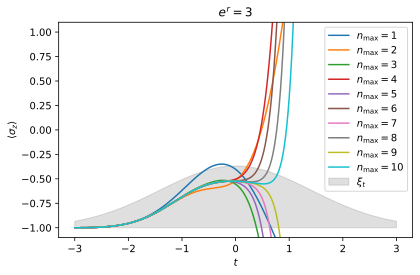

In [86]:
for n_max, soln in hard_cutoff_solns_er_3.items():
    field_ket = np.array([1] + n_max*[0])
    field_rho = np.outer(field_ket, field_ket)
    plt.plot(times, soln.get_expectations(sigz, field_rho), label=r'$n_\mathrm{{max}}={}$'.format(n_max))
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=3$')
plt.ylim(-1.1, 1.1)
plt.legend()
plt.tight_layout()

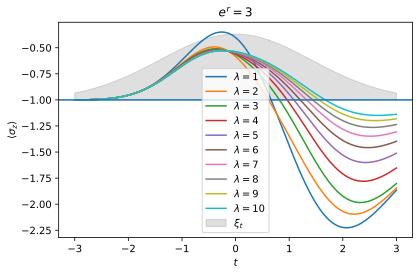

In [87]:
for decay_const, soln in exp_cutoff_solns_er_3.items():
    field_ket = np.array([1] + exp_cutoff_factories[decay_const].n_max*[0])
    field_rho = np.outer(field_ket, field_ket)
    plt.plot(times, soln.get_expectations(sigz, field_rho), label=r'$\lambda={}$'.format(decay_const))
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=3$')
plt.axhline(-1)
plt.legend()
plt.tight_layout()

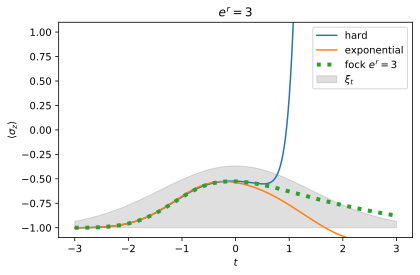

In [99]:
n_max = 10
hard_field_ket = np.array([1] + n_max*[0])
hard_field_rho = np.outer(hard_field_ket, hard_field_ket)
plt.plot(times, hard_cutoff_solns_er_3[n_max].get_expectations(sigz, hard_field_rho), label='hard')
decay_const = 10
exp_field_ket = np.array([1] + exp_cutoff_factories[decay_const].n_max*[0])
exp_field_rho = np.outer(exp_field_ket, exp_field_ket)
plt.plot(times, exp_cutoff_solns_er_3[n_max].get_expectations(sigz, exp_field_rho), label='exponential')
plt.plot(times, fock_soln.get_expectations(sigz, fock_field_rho_er_3), linestyle=':', linewidth=4, label='fock $e^r=3$')
plt.fill_between(times, xi_gau(times, Omega=1, ta=0) - 1, -1, color='k', alpha=0.125, zorder=-1, label=r'$\xi_t$')
plt.xlabel('$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title('$e^r=3$')
plt.ylim(-1.1, 1.1)
plt.legend()
plt.tight_layout()